In [49]:
import mnist_loader
import network
import numpy as np
from matplotlib import pyplot as plt

In [119]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

net = network.Network([784, 30, 10], cost=network.CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 10, 10, 0.5)
#evaluation_data=test_data , monitor_evaluation_accuracy=True

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete

Epoch 5 training complete

Epoch 6 training complete

Epoch 7 training complete

Epoch 8 training complete

Epoch 9 training complete



([], [], [], [])

In [41]:
test_in = np.transpose([np.squeeze(i[0]) for i in test_data])
posteriors = net.feedforward(test_in)
test_pred = np.argmax(posteriors,0)


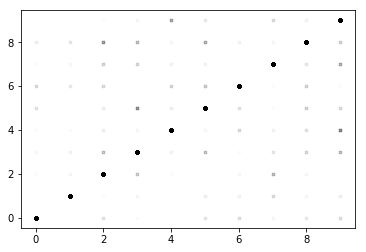

In [59]:
test_out = [i[1] for i in test_data]
plt.plot(test_out,test_pred,'k.',alpha=.01)

plt.show()

# Try autoendoder Network

In [159]:
# make training set, output = input
train_in = np.squeeze([i[0] for i in training_data])
t_ae = zip(train_in,train_in)
#tmp = train_in.tolist()
#np.shape(t_ae)
#np.shape(train_in)
tmp2 = zip(tmp,tmp)

In [168]:
np.shape(training_data)
type(t_ae[0][0])
#np.shape(t_ae)

numpy.ndarray

In [100]:
type(training_data)
np.shape(training_data)

# training data is (50000,2) list
# sub levels are (2,) tuple 
# sub sub is (784,1) tuple

(50000, 2)

In [102]:
np.shape(tmp)
type(train_in)
# type(training_data[0][0])

numpy.ndarray

In [122]:
np.shape(train_in)

(50000, 784)

In [93]:
foo = (5,6)
type(foo)

tuple

In [164]:
net_ae = network.Network([784, 30, 784], cost=network.CrossEntropyCost)
net_ae.large_weight_initializer()
net_ae.SGD(t_ae, 10, 10, 0.5)

ValueError: operands could not be broadcast together with shapes (784,30) (784,) 